In [49]:
import pandas as pd
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
torch.manual_seed(99)
import numpy as np
import copy

In [50]:
class CFG:
    seq_length = 10
    pred_length = 5
    epoch = 10

In [51]:
bit = pd.read_csv("BCHAIN-MKPRU.csv")

In [52]:
bit.head()

,Date,Value
0,9/11/16,621.65
1,9/12/16,609.67
2,9/13/16,610.92
3,9/14/16,608.82
4,9/15/16,610.38


In [53]:
class bitCoinDataset(Dataset):
    def __init__(self, dataset):
        self.target = (dataset.Value.astype(np.float32))
        
    def __len__(self):
        return len(self.target)-CFG.seq_length

    def __getitem__(self, i): 
        return (np.array(self.target[i:i+CFG.seq_length-CFG.pred_length]),np.array(self.target[i+CFG.seq_length-CFG.pred_length:i+CFG.seq_length]))

In [54]:
bd = bitCoinDataset(bit)

In [55]:
bd[0]

(array([621.65, 609.67, 610.92, 608.82, 610.38], dtype=float32),
 array([609.11, 607.04, 611.58, 610.19, 608.66], dtype=float32))

In [56]:
train_loader = DataLoader(bd, batch_size=1, shuffle=False)

In [57]:
from torch import nn

class ShallowRegressionLSTM(nn.Module):
    def __init__(self, num_sensors, hidden_units):
        super().__init__()
        self.num_sensors = num_sensors  # this is the number of features
        self.hidden_units = hidden_units
        self.num_layers = 1

        self.lstm = nn.LSTM(
            input_size=num_sensors,
            hidden_size=hidden_units,
            batch_first=True,
            num_layers=self.num_layers
        )

        self.linear = nn.Linear(in_features=self.hidden_units, out_features=1)

    def forward(self, x):
        batch_size = x.shape[0]
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()

        _, (hn, _) = self.lstm(x, (h0, c0))
        out = self.linear(hn[0]).flatten()  # First dim of Hn is num_layers, which is set to 1 above.

        return out

In [58]:
def my_loss(output,gt, output_diff, gt_diff):
    same = True
    with torch.no_grad():
        if output_diff*gt_diff<0:
            same = False
    if same:
        loss = torch.mean((output - gt)**2)
    else:
        loss = torch.mean((output - gt)**4)
    return loss

In [59]:
learning_rate = 2e-3
num_hidden_units = 8

model = ShallowRegressionLSTM(num_sensors=1, hidden_units=num_hidden_units)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [60]:
def update_input(input_array,output):
    tmp = list(input_array.detach().numpy())[0]
    for i in range(len(tmp)-1):
        tmp[i] = tmp[i+1]
    tmp[-1] = output
    return tmp

In [61]:
def train_model(data_loader, model, loss_function, optimizer):
    num_batches = len(data_loader)
    total_eval_loss = []
    total_train_loss = []
    prediction = []
    maximum = 0
    trade = dict()
    for i in range(len(bd)+CFG.seq_length+CFG.pred_length):
        trade[i] = []
    for idx, (X, y) in enumerate(data_loader):
        with torch.no_grad():
            maximum = max(X.reshape(CFG.seq_length-CFG.pred_length,)).item()
        with torch.no_grad():
            model.eval()
            # print("input:",X.reshape(1,CFG.seq_length-CFG.pred_length,-1))
            output = copy.deepcopy(X.reshape(1,CFG.seq_length-CFG.pred_length,-1))
            for l in range(CFG.pred_length):
                # print("input:",output.to(torch.float32)/maximum)
                pred = model(output.to(torch.float32)/maximum)
                trade[idx+l+CFG.seq_length-CFG.pred_length].append(pred.detach().item()*maximum)
                update_input(output, pred.detach().item()*maximum)
                # print("prediction",pred*maximum)
                # print("y",y[0][l])
                loss = loss_function(torch.tensor((pred*maximum).item()), y[0][l].to(torch.float32))
                total_eval_loss.append(loss)
       
        train_loss = 0
        for i in range(CFG.epoch):
            X = X.reshape(1,CFG.seq_length-CFG.pred_length,-1)
            y = y.reshape(1,CFG.pred_length,-1)
            model.train()
            # print("X",X)
            # print("y",y)
            #拿前seq_length数据进行训练
            output_prev = X[0][-1].to(torch.float32)/maximum
            gt_prev = X[0][-1].to(torch.float32)/maximum
            for i in range(CFG.pred_length):
                
                output = model(X.to(torch.float32)/maximum)
                # print("out",output*maximum)
                loss = loss_function(output*maximum, (y[0][i].to(torch.float32)))
                with torch.no_grad():
                    train_loss += loss
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                update_input(X, y[0][i].to(torch.float32).detach())
                # print("tf",X)
        total_train_loss.append(train_loss/CFG.epoch)

    return total_train_loss,total_eval_loss, trade


In [62]:
total_train_loss,total_eval_loss, trade = train_model(train_loader, model, loss_function, optimizer)

In [63]:
total_train_loss_list = [i.detach().item() for i in total_train_loss]

In [64]:
total_eval_loss_list = [i.detach().item() for i in total_eval_loss]

In [65]:
len(outputs)

1826

In [66]:
outputs = [0]*(CFG.seq_length-CFG.pred_length)+[trade[i][0] for i in range(CFG.seq_length-CFG.pred_length,len(bd)+CFG.seq_length-1)]+[trade[len(bd)+CFG.seq_length-2][0]]

In [68]:
outputs_csv = pd.DataFrame({"outputs":list(outputs),"gt":np.array(bit.Value),"train_loss":[0]*10+total_train_loss_list}).to_csv("bit_lstm.csv")

In [42]:
max(outputs_csv.train_loss.replace(9689158.0,1000).replace(912530.6875,1000))

8724.947265625

<AxesSubplot:ylabel='train_loss'>

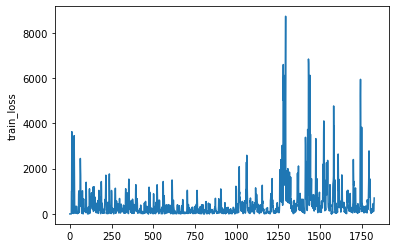

In [45]:
sns.lineplot(x = outputs_csv.index, y = outputs_csv.train_loss.replace(9689158.0,1000).replace(912530.6875,1000))

In [20]:
sns.lineplot(x=range(len(bit.Value)), y = bit.Value)
sns.lineplot(x=outputs_csv.index,y=[i for i in outputs_csv.outputs])

AttributeError: 'DataFrame' object has no attribute 'Value'

In [21]:
outputs_csv.to_csv("outputs.csv")

In [22]:
def calculate_difference(outputs, empty_days):
    out_difference = []
    for i in range(empty_days,len(outputs)-1):
        out_difference.append(outputs[i+1]-outputs[i])
    return out_difference

In [23]:
outputs_difference = calculate_difference(outputs_csv.outputs,20)
gt_difference = calculate_difference(outputs_csv["gt"],20)

TypeError: unsupported operand type(s) for -: 'list' and 'list'

In [24]:
sign_diff = []
assert len(outputs_difference) == len(gt_difference)
for i in range(len(outputs_difference)):
    sign_diff.append(outputs_difference[i]*gt_difference[i]>0)

NameError: name 'outputs_difference' is not defined